In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import csv
import cv2
import ast
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from PIL import Image, ImageDraw
!pip install "dask[bag]"
from dask import bag
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import top_k_categorical_accuracy
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline
from keras.backend import clear_session
from keras.layers import Activation, Reshape
from keras.models import Sequential, Model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Reshape, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.initializers import RandomNormal
#from keras.backend import clear_session
from keras.models import load_model

np.random.seed(0)
class_paths = glob('/content/drive/My Drive/quickdraw/train/*.csv')
#class_paths2 = pd.read_csv('/content/drive/My Drive/AI/input/generator_input.csv')
numstonames = {i: v[39:-4].replace(" ", "_") for i, v in enumerate(class_paths)}
print(numstonames)
namestonums = {v:k for k,v in numstonames.items()}

{0: '/diamond', 1: '/ear', 2: '/clock', 3: '/door', 4: '/camera', 5: '/hammer', 6: '/airplane', 7: '/cake', 8: '/butterfly', 9: '/bird', 10: '/ladder', 11: '/hat', 12: '/computer', 13: '/bee', 14: '/bicycle', 15: '/guitar', 16: '/hamburger', 17: '/cat', 18: '/leaf', 19: '/shoe', 20: '/star', 21: '/pencil', 22: '/chair', 23: '/sword', 24: '/lion', 25: '/scissors', 26: '/rabbit', 27: '/tree', 28: '/hand', 29: '/The_Eiffel_Tower'}


In [ ]:
def draw_it(strokes):
  image = Image.new("P", (256,256), color=255)
  image_draw = ImageDraw.Draw(image)
  for stroke in ast.literal_eval(strokes):
    for i in range(len(stroke[0])-1):
      image_draw.line([stroke[0][i],
                       stroke[1][i],
                       stroke[0][i+1],
                       stroke[1][i+1]],
                       fill=0, width=5)
  image = image.resize((imheight, imwidth))
  return 255-np.array(image)

In [ ]:
traindata = np.zeros((1, 64, 64))
testdata = np.zeros((1, 64, 64))


In [ ]:
for label in namestonums:
  print(label)
  num_classes = 30
  imheight, imwidth = 64, 64
  #ims_per_class = 5000
  #generator_test = pd.read_csv("/content/drive/My Drive/quickdraw/train/" + label + ".csv",nrows=ims_per_class)
  #generator_imagebag = bag.from_sequence(generator_test.drawing.values).map(draw_it)
  #generator_trainarray = np.array(generator_imagebag.compute())
  #A = np.append(A, generator_trainarray, axis = 0)
  #generator_trainarray1 = generator_trainarray.reshape(64, 64, 100)
  #np.concatenate((A, generator_trainarray1), axis = 2)
  #generator_X_train = ((generator_trainarray.astype(np.float32)/127.5)) - 1. #normalize to be [-1,1]
  #generator_num_train = generator_X_train.shape[0]
  #generator_X_train = generator_X_train.reshape(generator_num_train, imheight, imwidth, 1)


  ims_per_class = 6200
  test = pd.read_csv("/content/drive/My Drive/quickdraw/train/" + label + ".csv",nrows=ims_per_class)
  imagebag = bag.from_sequence(test.drawing.values).map(draw_it)
  trainarray = np.array(imagebag.compute())
  trainarray = trainarray.astype(np.float32)/255
  traindata = np.append(traindata, trainarray[0:5999], axis = 0)
  testdata = np.append(testdata, trainarray[6000:6200], axis = 0)
  #generator_trainarray1 = generator_trainarray.reshape(64, 64, 100)
  #np.concatenate((A, generator_trainarray1), axis = 2)
  #generator_X_train = ((generator_trainarray.astype(np.float32)/127.5)) - 1. #normalize to be [-1,1]
  #generator_num_train = generator_X_train.shape[0]
  #generator_X_train = generator_X_train.reshape(generator_num_train, imheight, imwidth, 1)


/diamond
/ear
/clock
/door
/camera
/hammer
/airplane
/cake
/butterfly
/bird
/ladder
/hat
/computer
/bee
/bicycle
/guitar
/hamburger
/cat
/leaf
/shoe
/star
/pencil
/chair
/sword
/lion
/scissors
/rabbit
/tree
/hand
/The_Eiffel_Tower


In [ ]:
#generator_trainarray[3][45][45]
traindata.shape

(179971, 64, 64)

In [ ]:

traindata = np.delete(traindata, (0), axis=0)

traindata.shape

(179970, 64, 64)

In [ ]:
testdata = np.delete(testdata, (0), axis=0)

testdata.shape

(6000, 64, 64)

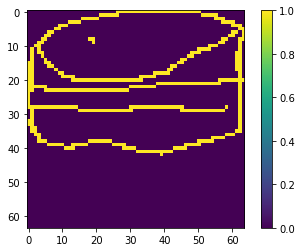

In [ ]:
plt.figure()
plt.imshow(testdata[1440])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
trainlable = []
for i in range(30):
  for j in range(5999):
    trainlable.append([i])
trainlable = np.array(trainlable)
trainlable.shape

(179970, 1)

In [ ]:
testlable = []
for i in range(30):
  for j in range(200):
    testlable.append([i])
testlable = np.array(testlable)
testlable.shape

(6000, 1)

In [ ]:
#model = keras.applications.ResNet50(weights='imagenet',
#                      include_top=False,
#                      input_shape=(64,64,1), pooling="avg")


#print(f"Now # of layers: {len(model.layers)}")
# model.summary()

#x = model.layers[-1].output

#x = Flatten()(x)

#x = Dense(512, name=f'added_dense1', activation='relu')(x)
#x = Dropout(0.5)(x)
#predictions = Dense(1, activation='sigmoid', name='predictions')(x)
# predictions = tf.keras.layers.Dense(2, activation='sigmoid', name='predictions')(x)
#model = tf.keras.Model(inputs=model.input, outputs=predictions)


#model.trainable = False
#for layer in model.layers:
#    layer.trainable = False

#model.trainable = True
#for layer in model.layers:
    # Boolean whether this layer is trainable.
#    trainable = ('added' in layer.name) or ('predictions' in layer.name)
    # trainable = ('added' in layer.name)
    # Set the layer's bool.
#    layer.trainable = trainable

#model.summary()
#print(f"Now # of layers: {len(model.layers)}")

In [ ]:
#from keras import backend as K

#def recall_m(y_true, y_pred):
#    TP = K.sum(y_true * K.round(y_pred))
#    TPandFN = K.sum(y_true)
#    recall = TP / (TPandFN + K.epsilon())
#    return recall

#def precision_m(y_true, y_pred):
#    TP = K.sum(y_true * K.round(y_pred))
#    TPandFP = K.sum(K.round(y_pred))
#    precision = TP / (TPandFP + K.epsilon())
#    return precision

#def f1_m(y_true, y_pred):
#    precision = precision_m(y_true, y_pred)
#    recall = recall_m(y_true, y_pred)
#    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', f1_m,precision_m, recall_m])
#opt = Adam(learning_rate=1e-4)
#model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc', f1_m,]) #precision_m, recall_m])
# model.compile(optimizer=opt, loss=f1_loss, metrics=['acc', f1_m])#,precision_m, recall_m])
# fit the model
#model.fit(traindata, trainlable, epochs=10)

In [ ]:
#model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(64, 64)),  # input layer (1)
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),  # hidden layer (2)
    keras.layers.Dense(30, activation='softmax') # output layer (3)
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(traindata, trainlable, batch_size = 128, epochs=8)

Epoch 1/8
1407/1407 [==============================] - 24s 16ms/step - loss: 1.5088 - accuracy: 0.5803
Epoch 2/8
1407/1407 [==============================] - 24s 17ms/step - loss: 0.5865 - accuracy: 0.8320
Epoch 3/8
1407/1407 [==============================] - 23s 16ms/step - loss: 0.3413 - accuracy: 0.9021
Epoch 4/8
1407/1407 [==============================] - 23s 17ms/step - loss: 0.1938 - accuracy: 0.9451
Epoch 5/8
1407/1407 [==============================] - 24s 17ms/step - loss: 0.1172 - accuracy: 0.9658
Epoch 6/8
1407/1407 [==============================] - 24s 17ms/step - loss: 0.0859 - accuracy: 0.9740
Epoch 7/8
1407/1407 [==============================] - 24s 17ms/step - loss: 0.0680 - accuracy: 0.9778
Epoch 8/8
1407/1407 [==============================] - 24s 17ms/step - loss: 0.0597 - accuracy: 0.9804


In [ ]:
test_loss, test_acc = model.evaluate(testdata,  testlable, verbose=1)

print('Test accuracy:', test_acc)

188/188 [==============================] - 1s 3ms/step - loss: 1.5257 - accuracy: 0.7667
Test accuracy: 0.7666666507720947


In [ ]:
##pip install -q pyyaml h5py
#!mkdir -p saved_model
#model.save('')
model.save('/content/drive/My Drive/quickdraw/model/classmodel.h5')

In [ ]:
predictions = model.predict(testdata)

In [ ]:
predictions[300]

array([1.3401976e-05, 9.8833883e-01, 8.0564450e-07, 2.5201422e-07,
       2.3002593e-11, 1.0004440e-02, 1.6602487e-05, 1.3099279e-08,
       1.9478724e-14, 5.8386085e-04, 1.2106006e-08, 1.2644920e-05,
       4.7199229e-08, 8.9318547e-10, 5.9427069e-10, 1.1292209e-10,
       1.4113614e-07, 6.6560060e-06, 4.8013547e-04, 1.4811921e-12,
       4.0658135e-10, 4.8733892e-09, 1.8120899e-08, 1.2963044e-09,
       5.1923632e-07, 3.7147505e-08, 1.7490366e-08, 5.4135814e-04,
       5.3178368e-08, 7.7943069e-10], dtype=float32)

In [ ]:
numstonames[np.argmax(predictions[300])]

'/ear'

In [ ]:
demo = np.zeros((1, 64, 64))
imheight, imwidth = 64, 64
test = pd.read_csv("/content/drive/My Drive/quickdraw/classifier_input.csv")
imagebag = bag.from_sequence(test.drawing.values).map(draw_it)
trainarray = np.array(imagebag.compute())
trainarray = trainarray.astype(np.float32)/255
demo = trainarray


demo.shape

(30, 64, 64)

In [ ]:
demopredictions = model.predict(demo)

In [ ]:
democsv = open("/content/drive/My Drive/quickdraw/classifier_input1.csv", 'r')
democsv = csv.reader(democsv)
C = open("/content/drive/My Drive/quickdraw/classifier_input1.csv", 'w')
C = csv.writer(C)

In [ ]:
demoinput = []
for j in range(30):
  demoinput.append(numstonames[np.argmax(demopredictions[j])])
print(demoinput)

['/pencil', '/scissors', '/rabbit', '/rabbit', '/ladder', '/cat', '/hat', '/airplane', '/star', '/sword', '/cake', '/computer', '/chair', '/pencil', '/clock', '/lion', '/pencil', '/hand', '/butterfly', '/tree', '/chair', '/bird', '/hammer', '/door', '/leaf', '/bird', '/shoe', '/butterfly', '/guitar', '/bird']


In [ ]:
with open("/content/drive/My Drive/quickdraw/classifier_input1.csv", 'r+') as f:
    writeCsv = csv.writer(f)
    writeCsv.writerow('word')
    writeCsv.writerows(demoinput)

In [ ]:
csvFile=open("/content/drive/My Drive/quickdraw/output.csv",'w',newline='')

writer=csv.writer(csvFile)
writer.writerow(('word'))
for i in range(29):
    writer.writerow(numstonames[np.argmax(demopredictions[j])])

In [ ]:
demopredictions = model.predict(demo)
democsv = next
i = 0
for item in democsv:
  item.append(numstonames[np.argmax(demopredictions[i])])
  i += 1

In [ ]:
with open("/content/drive/My Drive/quickdraw/classifier_input1.csv", 'w') as f:
    writedCsv = csv.DictWriter(f, headers)
    writedCsv.writeheader()
    writedCsv.writerows(rows)


In [ ]:
with open("/content/drive/My Drive/quickdraw/classifier_input1.csv", 'r') as csvinput:
  with open("/content/drive/My Drive/quickdraw/classifier_input1.csv", 'w') as csvoutput:
      writer = csv.writer(csvoutput, lineterminator='\n')
      reader = csv.reader(csvinput)

      all = []
      row = next(reader)
      row.append('word')
      all.append(row)
      i = 0
      for row in reader:
          row.append(numstonames[np.argmax(demopredictions[i])])
          all.append(row)
          i += 1

      writer.writerows(all)

In [ ]:
numstonames[np.argmax(demopredictions[13])]

'/clock'

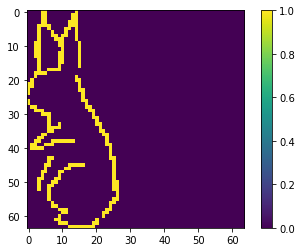

In [ ]:
plt.figure()
plt.imshow(demo[0])
plt.colorbar()
plt.grid(False)
plt.show()